# Fit J033226 Demo
------------------

This is the redshift 1 quasar we (I) chose for the examples for the Lightning paper; it turned out to be kind of a bad choice since it's a Type 1 and not super easy to fit, but we'll try again with `pLightning` and the benefit of hindsight.

Contents:
* Power-law fit
* `qsosed` fit

## Imports

In [1]:
import numpy as np
rng = np.random.default_rng()
import astropy.units as u
from astropy.table import Table
from astropy.io import ascii
from astropy.cosmology import FlatLambdaCDM
from corner import corner
import matplotlib.pyplot as plt
plt.style.use('ebm-dejavu')
%matplotlib inline

from lightning import Lightning
from lightning.priors import UniformPrior

## I/O
----------

In [2]:
phot = Table.read('example_photometry/J033226_lightning_input.fits')

redshift = phot['REDSHIFT'].data[0]
galactic_NH = phot['GALACTIC_NH'].data[0]
#filter_labels = phot['FILTER_LABELS'].data.flatten()
filter_labels = np.array([s.strip().decode() for s in phot['FILTER_LABELS'].data.flatten()])
fnu_obs = phot['FNU_OBS'].data.flatten() * 1e3 # converting Jy to mJy
fnu_unc = phot['FNU_UNC'].data.flatten() * 1e3

In [3]:
xray_phot = Table.read('example_photometry/J033226_xray_photometry.fits')

xray_filter_labels = np.array(['XRAY_%.3f_%.3f_keV' % (e1, e2) for e1, e2 in zip(xray_phot['ENERG_LO'], xray_phot['ENERG_HI'])])
net_counts = xray_phot['NET_COUNTS'].data.flatten()
net_counts_unc = xray_phot['NET_COUNTS_UNC'].data.flatten()

xray_exposure = xray_phot['EXPOSURE'].data[0]

In [4]:
filter_labels_full = np.concatenate((xray_filter_labels, filter_labels))
xray_mask = np.array(['XRAY' in s for s in filter_labels_full])
uvir_mask = ~xray_mask

fnu_obs_full = np.nan + np.zeros(len(filter_labels_full))
fnu_unc_full = np.zeros(len(filter_labels_full))
# net_counts_full = np.nan + np.zeros(len(filter_labels_full))
# net_counts_unc_full = np.zeros(len(filter_labels_full))

fnu_obs_full[uvir_mask] = fnu_obs
fnu_unc_full[uvir_mask] = fnu_unc

# Current setup is to stick X-ray counts in the flux array
fnu_obs_full[xray_mask] = net_counts
fnu_unc_full[xray_mask] = net_counts_unc

t = Table()
t['FILTER_LABELS'] = filter_labels_full
t['FLUX_OBS'] = fnu_obs_full
t['FLUX_UNC'] = fnu_unc_full
# t['XRAY_COUNTS'] = net_counts_full
# t['XRAY_COUNTS_UNC'] = net_counts_unc_full

t.show_in_notebook()

idx,FILTER_LABELS,FLUX_OBS,FLUX_UNC
0,XRAY_0.500_0.590_keV,103.16080387669922,17.06914388649152
1,XRAY_0.590_0.696_keV,105.2053121208817,17.39261962324014
2,XRAY_0.696_0.822_keV,159.13980601012312,22.506860760889985
3,XRAY_0.822_0.970_keV,220.28320154820105,28.426639814154843
4,XRAY_0.970_1.145_keV,252.40434296418772,31.560538780349464
5,XRAY_1.145_1.351_keV,252.55886556331126,31.66427014408168
6,XRAY_1.351_1.594_keV,259.58237594091764,32.537870928706354
7,XRAY_1.594_1.882_keV,237.50699902462856,30.63509272592005
8,XRAY_1.882_2.221_keV,108.6541633292519,19.791982010379417
9,XRAY_2.221_2.621_keV,76.37598680311142,16.38448381206126


In [5]:
arf = Table.read('example_photometry/J033226_unsummed.arf')

### Baseline Fit
----------------

Fitting with no X-ray model just to see how we do.

In [28]:
l0 = Lightning(filter_labels,
               redshift=redshift,
               #lum_dist=lum_dist,
               flux_obs=fnu_obs,
               flux_obs_unc=fnu_unc,
               wave_grid=(1e-1, 1e3, 1200),
               SFH_type='Piecewise-Constant',
               atten_type='Calzetti',
               dust_emission=True,
               agn_emission=True,
               xray_stellar_emission='None',
               xray_agn_emission='None',
               xray_absorption='None',
               galactic_NH=None,
               #xray_wave_grid=(1e-4, 1e-1, 200),
               #xray_arf=arf,
               #xray_exposure=xray_exposure,
               #xray_mode='counts',
               print_setup_time=True,
               model_unc=0.10
               )

0.235 s elapsed in _get_filters
0.001 s elapsed in _get_wave_obs
0.644 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
1.879 s elapsed in dust emission model setup
0.328 s elapsed in agn emission model setup
0.000 s elapsed in X-ray model setup
3.087 s elapsed total


In [29]:
p = np.array([5,5,1,1,1,
              0.1,
              2, 1, 3e5, 0.1, 0.01,
              11, np.sqrt(3)/2, 7])

# Currently the setup is to provide this mask that tells
# lightning which parameters are constant
const_dim = np.array([False, False, False, False, False,
                      False,
                      True, False, True, False, False,
                      False, True, False])

var_dim = ~const_dim

priors = [UniformPrior([0, 500]), # SFH
          UniformPrior([0, 500]),
          UniformPrior([0, 500]),
          UniformPrior([0, 500]),
          UniformPrior([0, 500]),
          UniformPrior([0, 3]), # tauV
          None, # alpha
          UniformPrior([0.1, 25]), # Umin
          None, # Umax
          UniformPrior([0,1]), # Gamma
          UniformPrior([0.0047, 0.0458]), #qPAH
          UniformPrior([10,13]), # log L_AGN -- constant here because we're using the qsosed model.
          None, # cos i
          UniformPrior([3,11]), # tau 9.7
          # None, # stellar pop. pho. index
          # UniformPrior([1e6,1e9]), # SMBH mass
          # UniformPrior([-1.5, 0.0]), # log Eddington ratio
          # UniformPrior([1, 500]) # NH
          ]

# Starting the MCMC in a very small Gaussian ball around the 'true' parameters
p0 = p[None, :] + rng.normal(loc=0, scale=1e-3, size=(75, len(p)))
p0[:, const_dim] = p[const_dim]

In [30]:
mcmc = l0.fit(p0, method='emcee', Nwalkers=75, Nsteps=5000, priors=priors, const_dim=const_dim)

100%|██████████| 5000/5000 [08:41<00:00,  9.58it/s]


In [31]:
print('MCMC mean acceptance fraction: %.3f' % (np.mean(mcmc.acceptance_fraction)))
chain = mcmc.get_chain(discard=1000, thin=300, flat=True)
logprob_chain = mcmc.get_log_prob(discard=1000, thin=300, flat=True)

MCMC mean acceptance fraction: 0.118


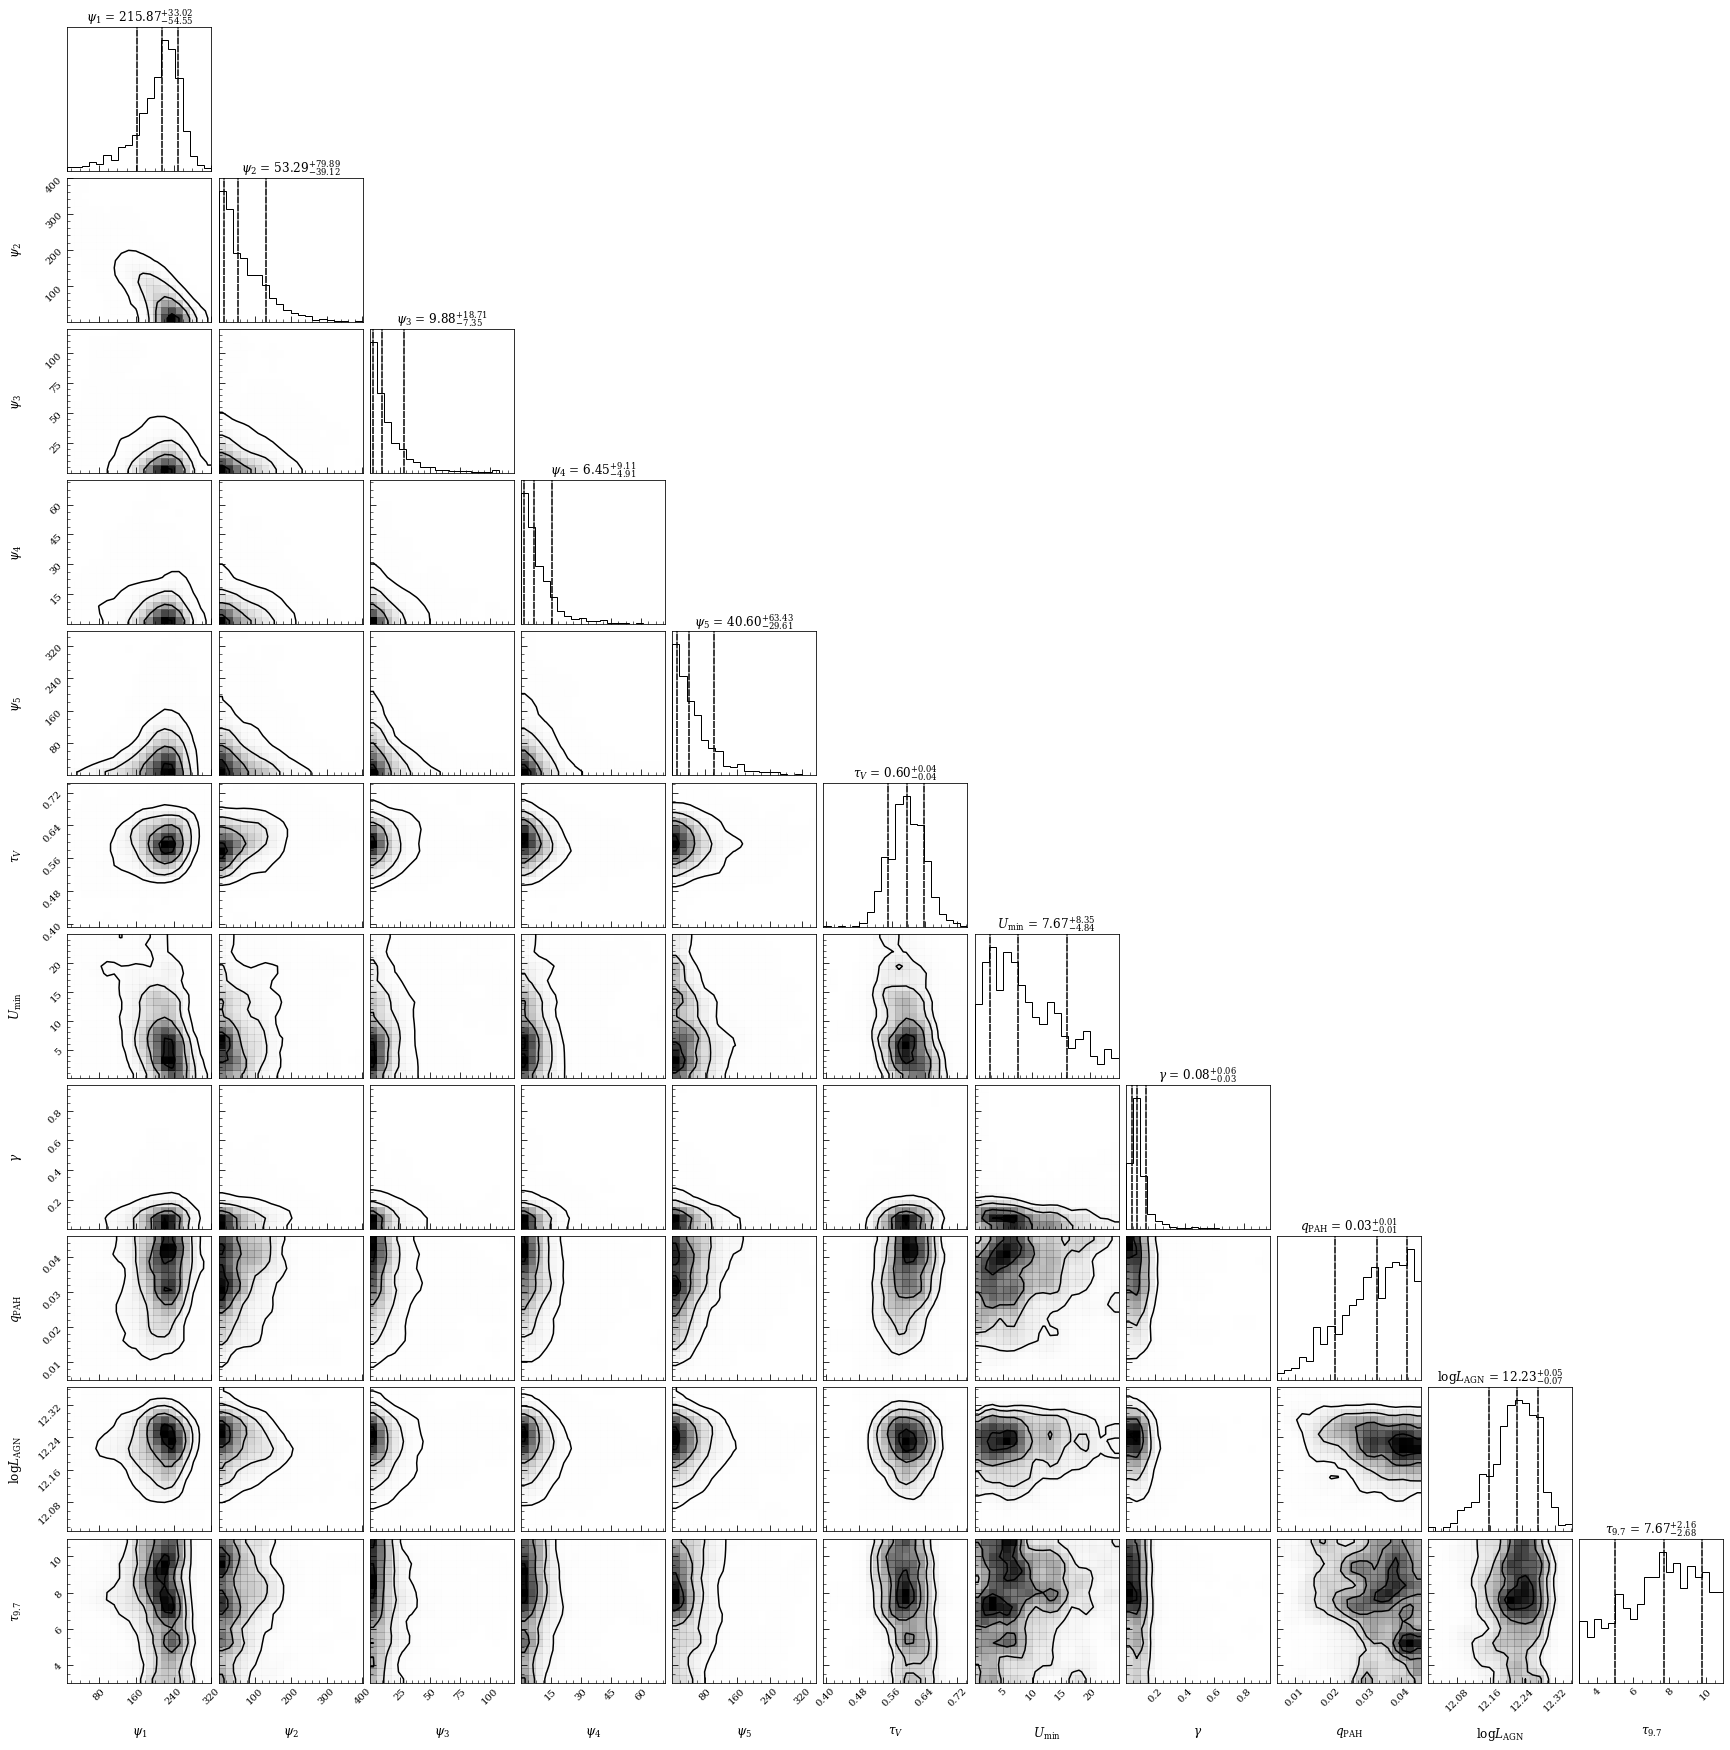

In [32]:
labels = [r'$\psi_1$', r'$\psi_2$', r'$\psi_3$', r'$\psi_4$', r'$\psi_5$',
          r'$\tau_V$', r'$U_{\rm min}$', r'$\gamma$', r'$q_{\rm PAH}$',
          r'$\log L_{\rm AGN}$', r'$\tau_{9.7}$']

# levels = np.array([0.68])
# levels_sigma = np.array([1,2,3])
# levels = 1 - np.exp(-0.5 * levels_sigma ** 2)
# print(levels)

fig = corner(chain,
             labels=labels,
             quantiles=(0.16, 0.50, 0.84),
             smooth=1,
             levels=None,
             show_titles=True)

In [33]:
# Get best-fitting SED
bestfit = np.argmax(logprob_chain)
bestfit_samples = chain[bestfit,:]
bestfit_params = p
bestfit_params[var_dim] = bestfit_samples

lnu_hires_best, lnu_hires_intr_best = l0.get_model_lnu_hires(bestfit_params)
lnu_best, lnu_intr_best = l0.get_model_lnu(bestfit_params)

# lnu_xray_hires_best, lnu_xray_hires_intr_best = l1.get_xray_model_lnu_hires(bestfit_params)
# lnu_xray_best, lnu_xray_intr_best = l1.get_xray_model_lnu(bestfit_params)
# counts_xray_best = l1.get_xray_model_counts(bestfit_params)
# lnu_obs_xray_best = counts_xray_best[xray_mask] / net_counts * lnu_xray_best[xray_mask]
# lnu_unc_xray_best = lnu_obs_xray_best / (net_counts / net_counts_unc)
#lmod_xray = 

lnu_unc_total = np.sqrt(l0.Lnu_unc**2 + (l0.model_unc * lnu_best)**2)
# lnu_xray_unc_total = np.sqrt(l1.Lnu_unc**2 + (l1.model_unc * lnu_xray_best)**2)

# Get the quantiles of the SFH
sfh_q = np.quantile(chain[:,:5], q=(0.16, 0.5, 0.84), axis=0)

(1000000.0, 13600000000.0)

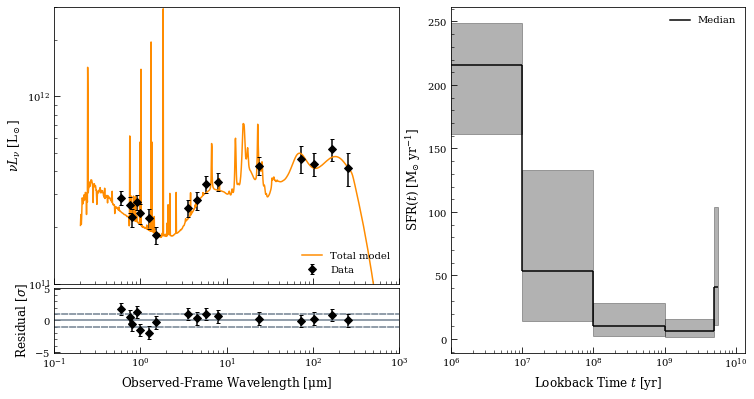

In [34]:
# fig, axs = plt.subplots(1,2, figsize=(12,6))
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_axes([0.1, 0.26, 0.4, 0.64])
ax2 = fig.add_axes([0.1, 0.1, 0.4, 0.15])
ax3 = fig.add_axes([0.56, 0.1, 0.34, 0.8])

# ax1.plot(l.wave_grid_obs, l.nu_grid_obs * lnu_hires_intr_best,
#             color='dodgerblue', label='Intrinsic spectrum')

ax1.plot(l0.wave_grid_obs, l0.nu_grid_obs * lnu_hires_best,
            color='darkorange', label='Total model')

ax1.errorbar(l0.wave_obs, l0.nu_obs * l0.Lnu_obs, yerr=l0.nu_obs * lnu_unc_total,
             marker='D', color='k', markerfacecolor='k', capsize=2, linestyle='',
             label='Data')

# ax1.errorbar(l.wave_obs, l.nu_obs * Lmod, yerr=0,
#              marker='D', color='limegreen', markerfacecolor='limegreen', capsize=2, linestyle='',
#              label='Truth')

# ax1.plot(l.xray_stellar_em.wave_grid_obs,
#          l.xray_stellar_em.nu_grid_obs * lnu_xray_hires_intr_best,
#          color='dodgerblue')
# ax1.plot(l2.xray_stellar_em.wave_grid_obs,
#          l2.xray_stellar_em.nu_grid_obs * lnu_xray_hires_best,
#          color='darkorange')
# ax1.errorbar(l2.xray_stellar_em.wave_obs[xray_mask],
#              l2.xray_stellar_em.nu_obs[xray_mask] * lnu_obs_xray_best,
#              yerr=lnu_unc_xray_best,
#              marker='D', color='k', markerfacecolor='k', capsize=2, linestyle='')
# ax1.errorbar(l.xray_stellar_em.wave_obs,
#              l.xray_stellar_em.nu_obs * Lmod_xray,
#              yerr=0,
#              marker='D', color='limegreen', markerfacecolor='limegreen', capsize=2, linestyle='')

#ax1.set_xlabel(r'Observed-Frame Wavelength $[\rm \mu m]$')
ax1.set_ylabel(r'$\nu L_{\nu}\ [\rm L_\odot]$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1e-1, 1e3)
ax1.set_ylim(1e11, 3e12)
ax1.legend(loc='lower right')
ax1.set_xticklabels([])

delchi = (l0.Lnu_obs - lnu_best) / lnu_unc_total

ax2.axhline(0, color='slategray', linestyle='-')
ax2.axhline(-1, color='slategray', linestyle='--')
ax2.axhline(1, color='slategray', linestyle='--')

ax2.errorbar(l0.wave_obs, delchi, yerr=(1 + np.zeros_like(delchi)),
             marker='D', color='k', markerfacecolor='k', capsize=2, linestyle='')

#delchi_xray = (l.Lnu_obs - lnu_xray_best) / lnu_xray_unc_total
# delchi_xray = (counts_xray_best[xray_mask] - net_counts) / net_counts_unc

# ax2.errorbar(l2.xray_stellar_em.wave_obs[xray_mask],
#              delchi_xray,
#              yerr=(1 + np.zeros_like(delchi_xray)),
#              marker='D',
#              color='k',
#              markerfacecolor='k',
#              capsize=2,
#              linestyle='')

ax2.set_xscale('log')
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(-5.1,5.1)

ax2.set_xlabel(r'Observed-Frame Wavelength $[\rm \mu m]$')
ax2.set_ylabel(r'Residual $[\sigma]$')

# Making nice step plots remains an annoyance
#print(sfh_q.shape)
for i in np.arange(len(l0.ages) - 1):
    ax3.fill_between([l0.ages[i], l0.ages[i+1]],
                        [sfh_q[0,i], sfh_q[0,i]], 
                        [sfh_q[2,i], sfh_q[2,i]],
                        color='k', alpha=0.3)
    lines = ax3.hlines(sfh_q[1,i], l0.ages[i], l0.ages[i+1], color='k')
    if (i < len(l0.ages) - 2): 
        ax3.vlines(l0.ages[i+1], sfh_q[1,i], sfh_q[1,i+1], color='k')

ax3.legend([lines], ['Median'], loc='upper right')

ax3.set_xlabel(r'Lookback Time $t$ [yr]')
ax3.set_ylabel(r'${\rm SFR}(t)\ [\rm M_{\odot}\ yr^{-1}]$')
        
ax3.set_xscale('log')
ax3.set_xlim(1e6,13.6*10**9)

## `qsosed` Fit
----------------

### Initialization

In [15]:
l1 = Lightning(filter_labels_full,
               redshift=redshift,
               #lum_dist=lum_dist,
               flux_obs=fnu_obs_full,
               flux_obs_unc=fnu_unc_full,
               wave_grid=(1e-1, 1e3, 1200),
               SFH_type='Piecewise-Constant',
               atten_type='Calzetti',
               dust_emission=True,
               agn_emission=True,
               xray_stellar_emission='Stellar-Plaw',
               xray_agn_emission='QSOSED',
               xray_absorption='tbabs',
               galactic_NH=galactic_NH,
               xray_wave_grid=(1e-4, 1e-1, 200),
               xray_arf=arf,
               xray_exposure=xray_exposure,
               xray_mode='counts',
               print_setup_time=True,
               model_unc=0.10
               )

0.247 s elapsed in _get_filters
0.001 s elapsed in _get_wave_obs
0.662 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
2.186 s elapsed in dust emission model setup
0.250 s elapsed in agn emission model setup
0.559 s elapsed in X-ray model setup
3.905 s elapsed total


In [8]:
l1.print_params(verbose=True)


Piecewise-Constant
Parameter  Lo  Hi              Description
--------- --- --- ------------------------
    psi_1 0.0 inf SFR in stellar age bin 1
    psi_2 0.0 inf SFR in stellar age bin 2
    psi_3 0.0 inf SFR in stellar age bin 3
    psi_4 0.0 inf SFR in stellar age bin 4
    psi_5 0.0 inf SFR in stellar age bin 5

Calzetti
     Parameter  Lo  Hi                      Description
-------------- --- --- --------------------------------
calz_tauV_diff 0.0 inf Optical depth of the diffuse ISM

DL07-Dust
      Parameter     Lo       Hi                                                             Description
--------------- ------ -------- -----------------------------------------------------------------------
dl07_dust_alpha  -10.0      4.0                  Radiation field intensity distribution power law index
dl07_dust_U_min    0.1     25.0                                       Radiation field minimum intensity
dl07_dust_U_max 1000.0 300000.0                                       Radi

In [38]:
# qsosed = l1.xray_agn_em

# print(qsosed._mass_grid.shape)
# print(qsosed._mass_vec)
# print(qsosed._mdot_vec)
# print(qsosed.phot_energ)
# print(qsosed.energ_grid_obs)
# print(qsosed.energ_obs)

In [16]:
p = np.array([5,5,1,1,1,
              0.1,
              2, 1, 3e5, 0.1, 0.01,
              11, np.sqrt(3)/2, 7,
              1.8,
              8, -1.0,
              100.0])

# Currently the setup is to provide this mask that tells
# lightning which parameters are constant
const_dim = np.array([False, False, False, False, False,
                      False,
                      True, False, True, False, False,
                      True, True, False,
                      True,
                      False, False,
                      False])

var_dim = ~const_dim

priors = [UniformPrior([0, 5e2]), # SFH
          UniformPrior([0, 5e2]),
          UniformPrior([0, 5e2]),
          UniformPrior([0, 5e2]),
          UniformPrior([0, 5e2]),
          UniformPrior([0, 3]), # tauV
          None, # alpha
          UniformPrior([0.1, 25]), # Umin
          None, # Umax
          UniformPrior([0,1]), # Gamma
          UniformPrior([0.0047, 0.0458]), #qPAH
          None, # log L_AGN -- constant here because we're using the qsosed model.
          None, # cos i
          UniformPrior([3,11]), # tau 9.7
          None, # stellar pop. pho. index
          UniformPrior([8,9.5]), # SMBH mass
          UniformPrior([-1.5, 0.0]), # log Eddington ratio
          UniformPrior([1, 500]) # NH
          ]

# Starting the MCMC in a very small Gaussian ball around the 'true' parameters
p0 = p[None, :] + rng.normal(loc=0, scale=1e-3, size=(75, len(p)))
p0[:, const_dim] = p[const_dim]

In [17]:
mcmc = l1.fit(p0, method='emcee', Nwalkers=75, Nsteps=8000, priors=priors, const_dim=const_dim)

/Users/Erik/Documents/Research/lightning/plightning/lightning/xray/agn.py:610: RuntimeWarning: divide by zero encountered in log10
  np.log10(lnu_obs) + np.log10(self.specresp) - np.log10(self.phot_energ)
100%|██████████| 8000/8000 [21:00<00:00,  6.35it/s]  


In [18]:
print('MCMC mean acceptance fraction: %.3f' % (np.mean(mcmc.acceptance_fraction)))
chain = mcmc.get_chain(discard=1000, thin=300, flat=True)
logprob_chain = mcmc.get_log_prob(discard=1000, thin=300, flat=True)

MCMC mean acceptance fraction: 0.046


### SFH Chain Plot

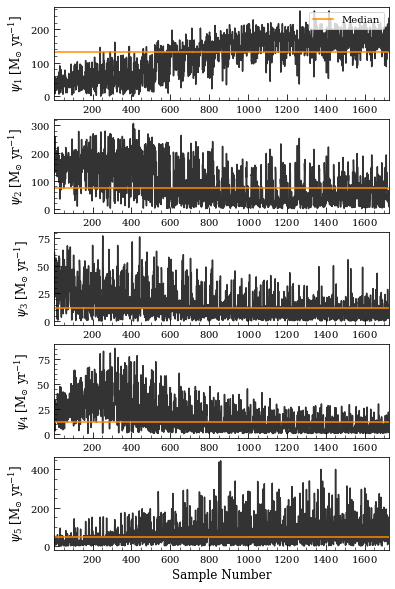

In [19]:
fig, axs = plt.subplots(5,1, figsize=(6,10))

t = np.arange(len(chain[:,0])) + 1
for i in np.arange(5):
    axs[i].plot(t, chain[:,i], color='k', alpha=0.8)
    axs[i].axhline(np.median(chain[:,i]), color='darkorange', label='Median')
    #axs[i].axhline(1, color='dodgerblue', label='Truth')
    axs[i].set_ylabel(r'$\psi_%d\ [\rm M_{\odot}\ yr^{-1}]$' % (i + 1))
    axs[i].set_xlim(1,t[-1])
    #axs[i].set_yscale('log')

axs[4].set_xlabel('Sample Number')

axs[0].legend(loc='upper right', frameon=True)

### Corner Plot

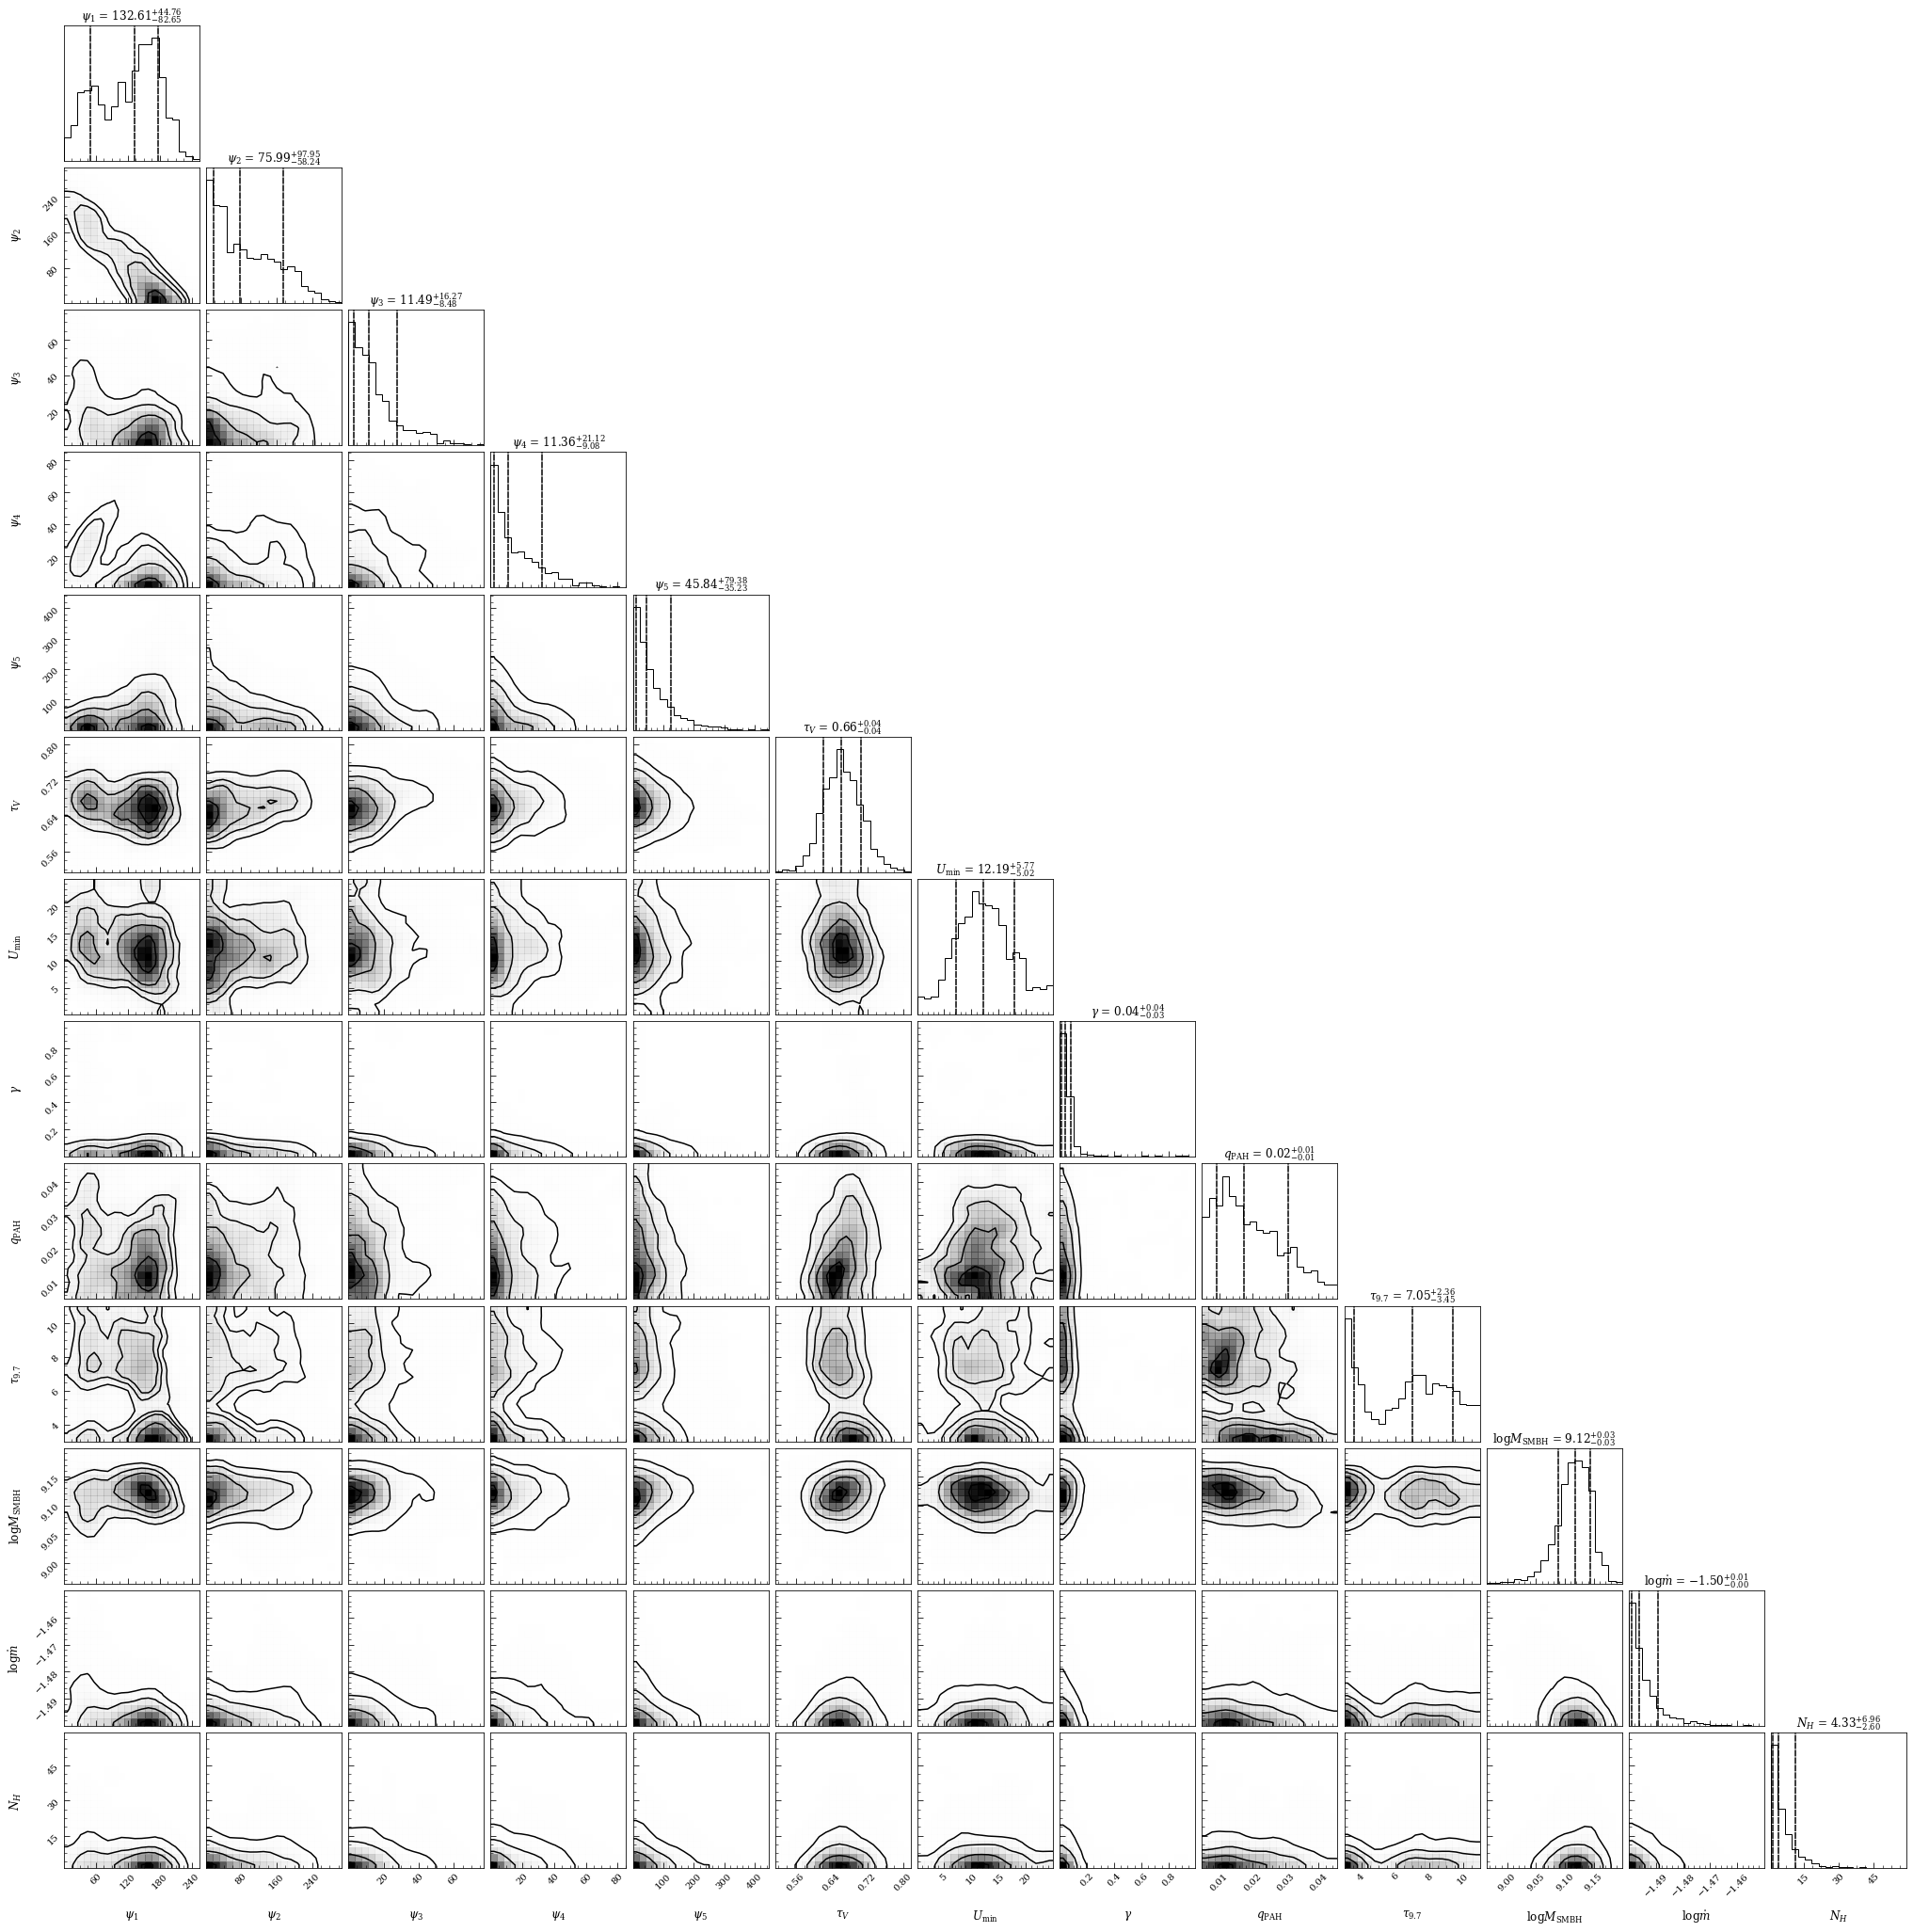

In [20]:
labels = [r'$\psi_1$', r'$\psi_2$', r'$\psi_3$', r'$\psi_4$', r'$\psi_5$',
          r'$\tau_V$', r'$U_{\rm min}$', r'$\gamma$', r'$q_{\rm PAH}$',
          r'$\tau_{9.7}$', r'$\log M_{\rm SMBH}$', r'$\log \dot m$', r'$N_H$']

# levels = np.array([0.68])
# levels_sigma = np.array([1,2,3])
# levels = 1 - np.exp(-0.5 * levels_sigma ** 2)
# print(levels)

fig = corner(chain,
             labels=labels,
             quantiles=(0.16, 0.50, 0.84),
             smooth=1,
             levels=None,
             show_titles=True)

### SED/SFH Plot

In [23]:
# Get best-fitting SED
bestfit = np.argmax(logprob_chain)
bestfit_samples = chain[bestfit,:]
bestfit_params = p
bestfit_params[var_dim] = bestfit_samples

lnu_hires_best, lnu_hires_intr_best = l1.get_model_lnu_hires(bestfit_params)
lnu_best, lnu_intr_best = l1.get_model_lnu(bestfit_params)

lnu_xray_hires_best, lnu_xray_hires_intr_best = l1.get_xray_model_lnu_hires(bestfit_params)
lnu_xray_best, lnu_xray_intr_best = l1.get_xray_model_lnu(bestfit_params)
counts_xray_best = l1.get_xray_model_counts(bestfit_params)
lnu_obs_xray_best = net_counts / counts_xray_best[xray_mask]  * lnu_xray_best[xray_mask]
lnu_unc_xray_best = lnu_obs_xray_best / (net_counts / net_counts_unc)
#lmod_xray = 

lnu_unc_total = np.sqrt(l1.Lnu_unc**2 + (l1.model_unc * lnu_best)**2)
lnu_xray_unc_total = np.sqrt(l1.Lnu_unc**2 + (l1.model_unc * lnu_xray_best)**2)

# Get the quantiles of the SFH
sfh_q = np.quantile(chain[:,:5], q=(0.16, 0.5, 0.84), axis=0)

(1000000.0, 13600000000.0)

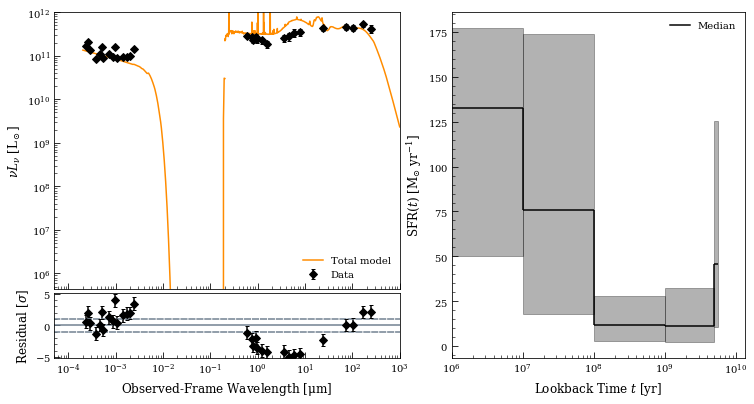

In [25]:
# fig, axs = plt.subplots(1,2, figsize=(12,6))
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_axes([0.1, 0.26, 0.4, 0.64])
ax2 = fig.add_axes([0.1, 0.1, 0.4, 0.15])
ax3 = fig.add_axes([0.56, 0.1, 0.34, 0.8])

# ax1.plot(l.wave_grid_obs, l.nu_grid_obs * lnu_hires_intr_best,
#             color='dodgerblue', label='Intrinsic spectrum')

ax1.plot(l1.wave_grid_obs, l1.nu_grid_obs * lnu_hires_best,
            color='darkorange', label='Total model')

ax1.errorbar(l1.wave_obs, l1.nu_obs * l1.Lnu_obs, yerr=l1.nu_obs * lnu_unc_total,
             marker='D', color='k', markerfacecolor='k', capsize=2, linestyle='',
             label='Data')

# ax1.errorbar(l.wave_obs, l.nu_obs * Lmod, yerr=0,
#              marker='D', color='limegreen', markerfacecolor='limegreen', capsize=2, linestyle='',
#              label='Truth')

# ax1.plot(l.xray_stellar_em.wave_grid_obs,
#          l.xray_stellar_em.nu_grid_obs * lnu_xray_hires_intr_best,
#          color='dodgerblue')
ax1.plot(l1.xray_stellar_em.wave_grid_obs,
         l1.xray_stellar_em.nu_grid_obs * lnu_xray_hires_best,
         color='darkorange')
ax1.errorbar(l1.xray_stellar_em.wave_obs[xray_mask],
             l1.xray_stellar_em.nu_obs[xray_mask] * lnu_obs_xray_best,
             yerr=lnu_unc_xray_best,
             marker='D', color='k', markerfacecolor='k', capsize=2, linestyle='')
# ax1.errorbar(l.xray_stellar_em.wave_obs,
#              l.xray_stellar_em.nu_obs * Lmod_xray,
#              yerr=0,
#              marker='D', color='limegreen', markerfacecolor='limegreen', capsize=2, linestyle='')

#ax1.set_xlabel(r'Observed-Frame Wavelength $[\rm \mu m]$')
ax1.set_ylabel(r'$\nu L_{\nu}\ [\rm L_\odot]$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(5e-5, 1e3)
ax1.set_ylim(0.9 * 5e5, 1e12)
ax1.legend(loc='lower right')
ax1.set_xticklabels([])

delchi = (l1.Lnu_obs - lnu_best) / lnu_unc_total

ax2.axhline(0, color='slategray', linestyle='-')
ax2.axhline(-1, color='slategray', linestyle='--')
ax2.axhline(1, color='slategray', linestyle='--')

ax2.errorbar(l1.wave_obs, delchi, yerr=(1 + np.zeros_like(delchi)),
             marker='D', color='k', markerfacecolor='k', capsize=2, linestyle='')

#delchi_xray = (l.Lnu_obs - lnu_xray_best) / lnu_xray_unc_total
delchi_xray = (net_counts - counts_xray_best[xray_mask]) / net_counts_unc

ax2.errorbar(l1.xray_stellar_em.wave_obs[xray_mask],
             delchi_xray,
             yerr=(1 + np.zeros_like(delchi_xray)),
             marker='D',
             color='k',
             markerfacecolor='k',
             capsize=2,
             linestyle='')

ax2.set_xscale('log')
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(-5.1,5.1)

ax2.set_xlabel(r'Observed-Frame Wavelength $[\rm \mu m]$')
ax2.set_ylabel(r'Residual $[\sigma]$')

# Making nice step plots remains an annoyance
#print(sfh_q.shape)
for i in np.arange(len(l1.ages) - 1):
    ax3.fill_between([l1.ages[i], l1.ages[i+1]],
                        [sfh_q[0,i], sfh_q[0,i]], 
                        [sfh_q[2,i], sfh_q[2,i]],
                        color='k', alpha=0.3)
    lines = ax3.hlines(sfh_q[1,i], l1.ages[i], l1.ages[i+1], color='k')
    if (i < len(l1.ages) - 2): 
        ax3.vlines(l1.ages[i+1], sfh_q[1,i], sfh_q[1,i+1], color='k')

ax3.legend([lines], ['Median'], loc='upper right')

ax3.set_xlabel(r'Lookback Time $t$ [yr]')
ax3.set_ylabel(r'${\rm SFR}(t)\ [\rm M_{\odot}\ yr^{-1}]$')
        
ax3.set_xscale('log')
ax3.set_xlim(1e6,13.6*10**9)

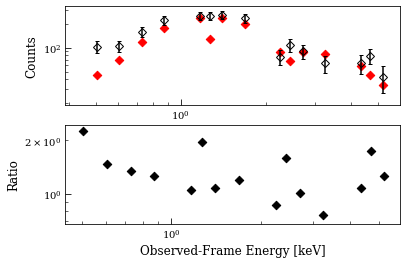

In [26]:
fig, axs = plt.subplots(2,1)

axs[0].errorbar(l1.xray_agn_em.energ_obs[xray_mask],
            net_counts,
            yerr=net_counts_unc,
            marker='D', capsize=2,
            linestyle='')
axs[0].scatter(l1.xray_agn_em.energ_obs[xray_mask],
           counts_xray_best[xray_mask],
           marker='D', color='red')

axs[0].set_xlabel('Observed-Frame Energy [keV]')
axs[0].set_ylabel('Counts')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[1].scatter(l1.xray_agn_em.energ_obs[xray_mask],
               net_counts / counts_xray_best[xray_mask],
               marker='D')

axs[1].set_xlabel('Observed-Frame Energy [keV]')
axs[1].set_ylabel('Ratio')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

## Power-Law Fit
----------------

### Initialization

In [6]:
l2 = Lightning(filter_labels_full,
               redshift=redshift,
               #lum_dist=lum_dist,
               flux_obs=fnu_obs_full,
               flux_obs_unc=fnu_unc_full,
               wave_grid=(1e-1, 1e3, 1200),
               SFH_type='Piecewise-Constant',
               atten_type='Calzetti',
               dust_emission=True,
               agn_emission=True,
               xray_stellar_emission='Stellar-Plaw',
               xray_agn_emission='AGN-Plaw',
               xray_absorption='tbabs',
               galactic_NH=galactic_NH,
               xray_wave_grid=(1e-4, 1e-1, 200),
               xray_arf=arf,
               xray_exposure=xray_exposure,
               xray_mode='counts',
               print_setup_time=True,
               model_unc=0.10
               )

/Users/Erik/Documents/Research/lightning/plightning/lightning/get_filters.py:143: RuntimeWarning: invalid value encountered in true_divide
  transm_norm_interp = transm_interp / trapz(transm_interp, wave_grid)


0.354 s elapsed in _get_filters
0.001 s elapsed in _get_wave_obs
1.035 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
3.035 s elapsed in dust emission model setup
0.431 s elapsed in agn emission model setup
0.559 s elapsed in X-ray model setup
5.415 s elapsed total


In [7]:
p = np.array([5,5,1,1,1,
              0.1,
              2, 1, 3e5, 0.1, 0.01,
              11, np.sqrt(3)/2, 7,
              1.8,
              1.8, 0.0,
              100.0])

# Currently the setup is to provide this mask that tells
# lightning which parameters are constant
const_dim = np.array([False, False, False, False, False,
                      False,
                      True, False, True, False, False,
                      False, True, False,
                      True,
                      True, False,
                      False])

var_dim = ~const_dim

priors = [UniformPrior([0, 5e2]), # SFH
          UniformPrior([0, 5e2]),
          UniformPrior([0, 5e2]),
          UniformPrior([0, 5e2]),
          UniformPrior([0, 5e2]),
          UniformPrior([0, 3]), # tauV
          None, # alpha
          UniformPrior([0.1, 25]), # Umin
          None, # Umax
          UniformPrior([0,1]), # Gamma
          UniformPrior([0.0047, 0.0458]), #qPAH
          UniformPrior([11,13]), # log L_AGN
          None, # cos i
          UniformPrior([3,11]), # tau 9.7
          None, # stellar pop. pho. index
          None, # Phot. Index
          UniformPrior([-0.6, 0.6]), # deviation from LR17
          UniformPrior([1, 500]) # NH
          ]

# Starting the MCMC in a very small Gaussian ball around the 'true' parameters
p0 = p[None, :] + rng.normal(loc=0, scale=1e-3, size=(75, len(p)))
p0[:, const_dim] = p[const_dim]

In [8]:
mcmc = l2.fit(p0, method='emcee', Nwalkers=75, Nsteps=5000, priors=priors, const_dim=const_dim)

/Users/Erik/Documents/Research/lightning/plightning/lightning/lightning.py:1463: RuntimeWarning: divide by zero encountered in log
  log_prior[ib_mask] = np.log(np.prod(prior_arr, axis=1))
/Users/Erik/Documents/Research/lightning/plightning/lightning/xray/stellar.py:220: RuntimeWarning: divide by zero encountered in log10
  np.log10(lnu_obs) + np.log10(self.specresp[None, :]) - np.log10(self.phot_energ[None,:])
/Users/Erik/Documents/Research/lightning/plightning/lightning/xray/agn.py:184: RuntimeWarning: divide by zero encountered in log10
  np.log10(lnu_obs) + np.log10(self.specresp) - np.log10(self.phot_energ)
  0%|          | 0/5000 [00:00<?, ?it/s]/Users/Erik/miniconda3/envs/astroconda3/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [13:58<00:00,  5.96it/s]


In [9]:
print('MCMC mean acceptance fraction: %.3f' % (np.mean(mcmc.acceptance_fraction)))
chain = mcmc.get_chain(discard=1000, thin=300, flat=True)
logprob_chain = mcmc.get_log_prob(discard=1000, thin=300, flat=True)

MCMC mean acceptance fraction: 0.092


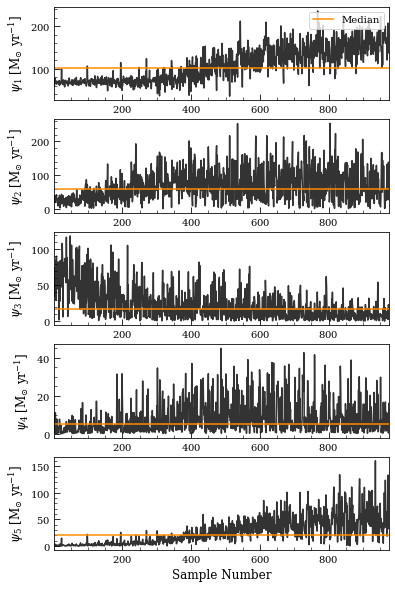

In [10]:
fig, axs = plt.subplots(5,1, figsize=(6,10))

t = np.arange(len(chain[:,0])) + 1
for i in np.arange(5):
    axs[i].plot(t, chain[:,i], color='k', alpha=0.8)
    axs[i].axhline(np.median(chain[:,i]), color='darkorange', label='Median')
    #axs[i].axhline(1, color='dodgerblue', label='Truth')
    axs[i].set_ylabel(r'$\psi_%d\ [\rm M_{\odot}\ yr^{-1}]$' % (i + 1))
    axs[i].set_xlim(1,t[-1])
    #axs[i].set_yscale('log')

axs[4].set_xlabel('Sample Number')

axs[0].legend(loc='upper right', frameon=True)

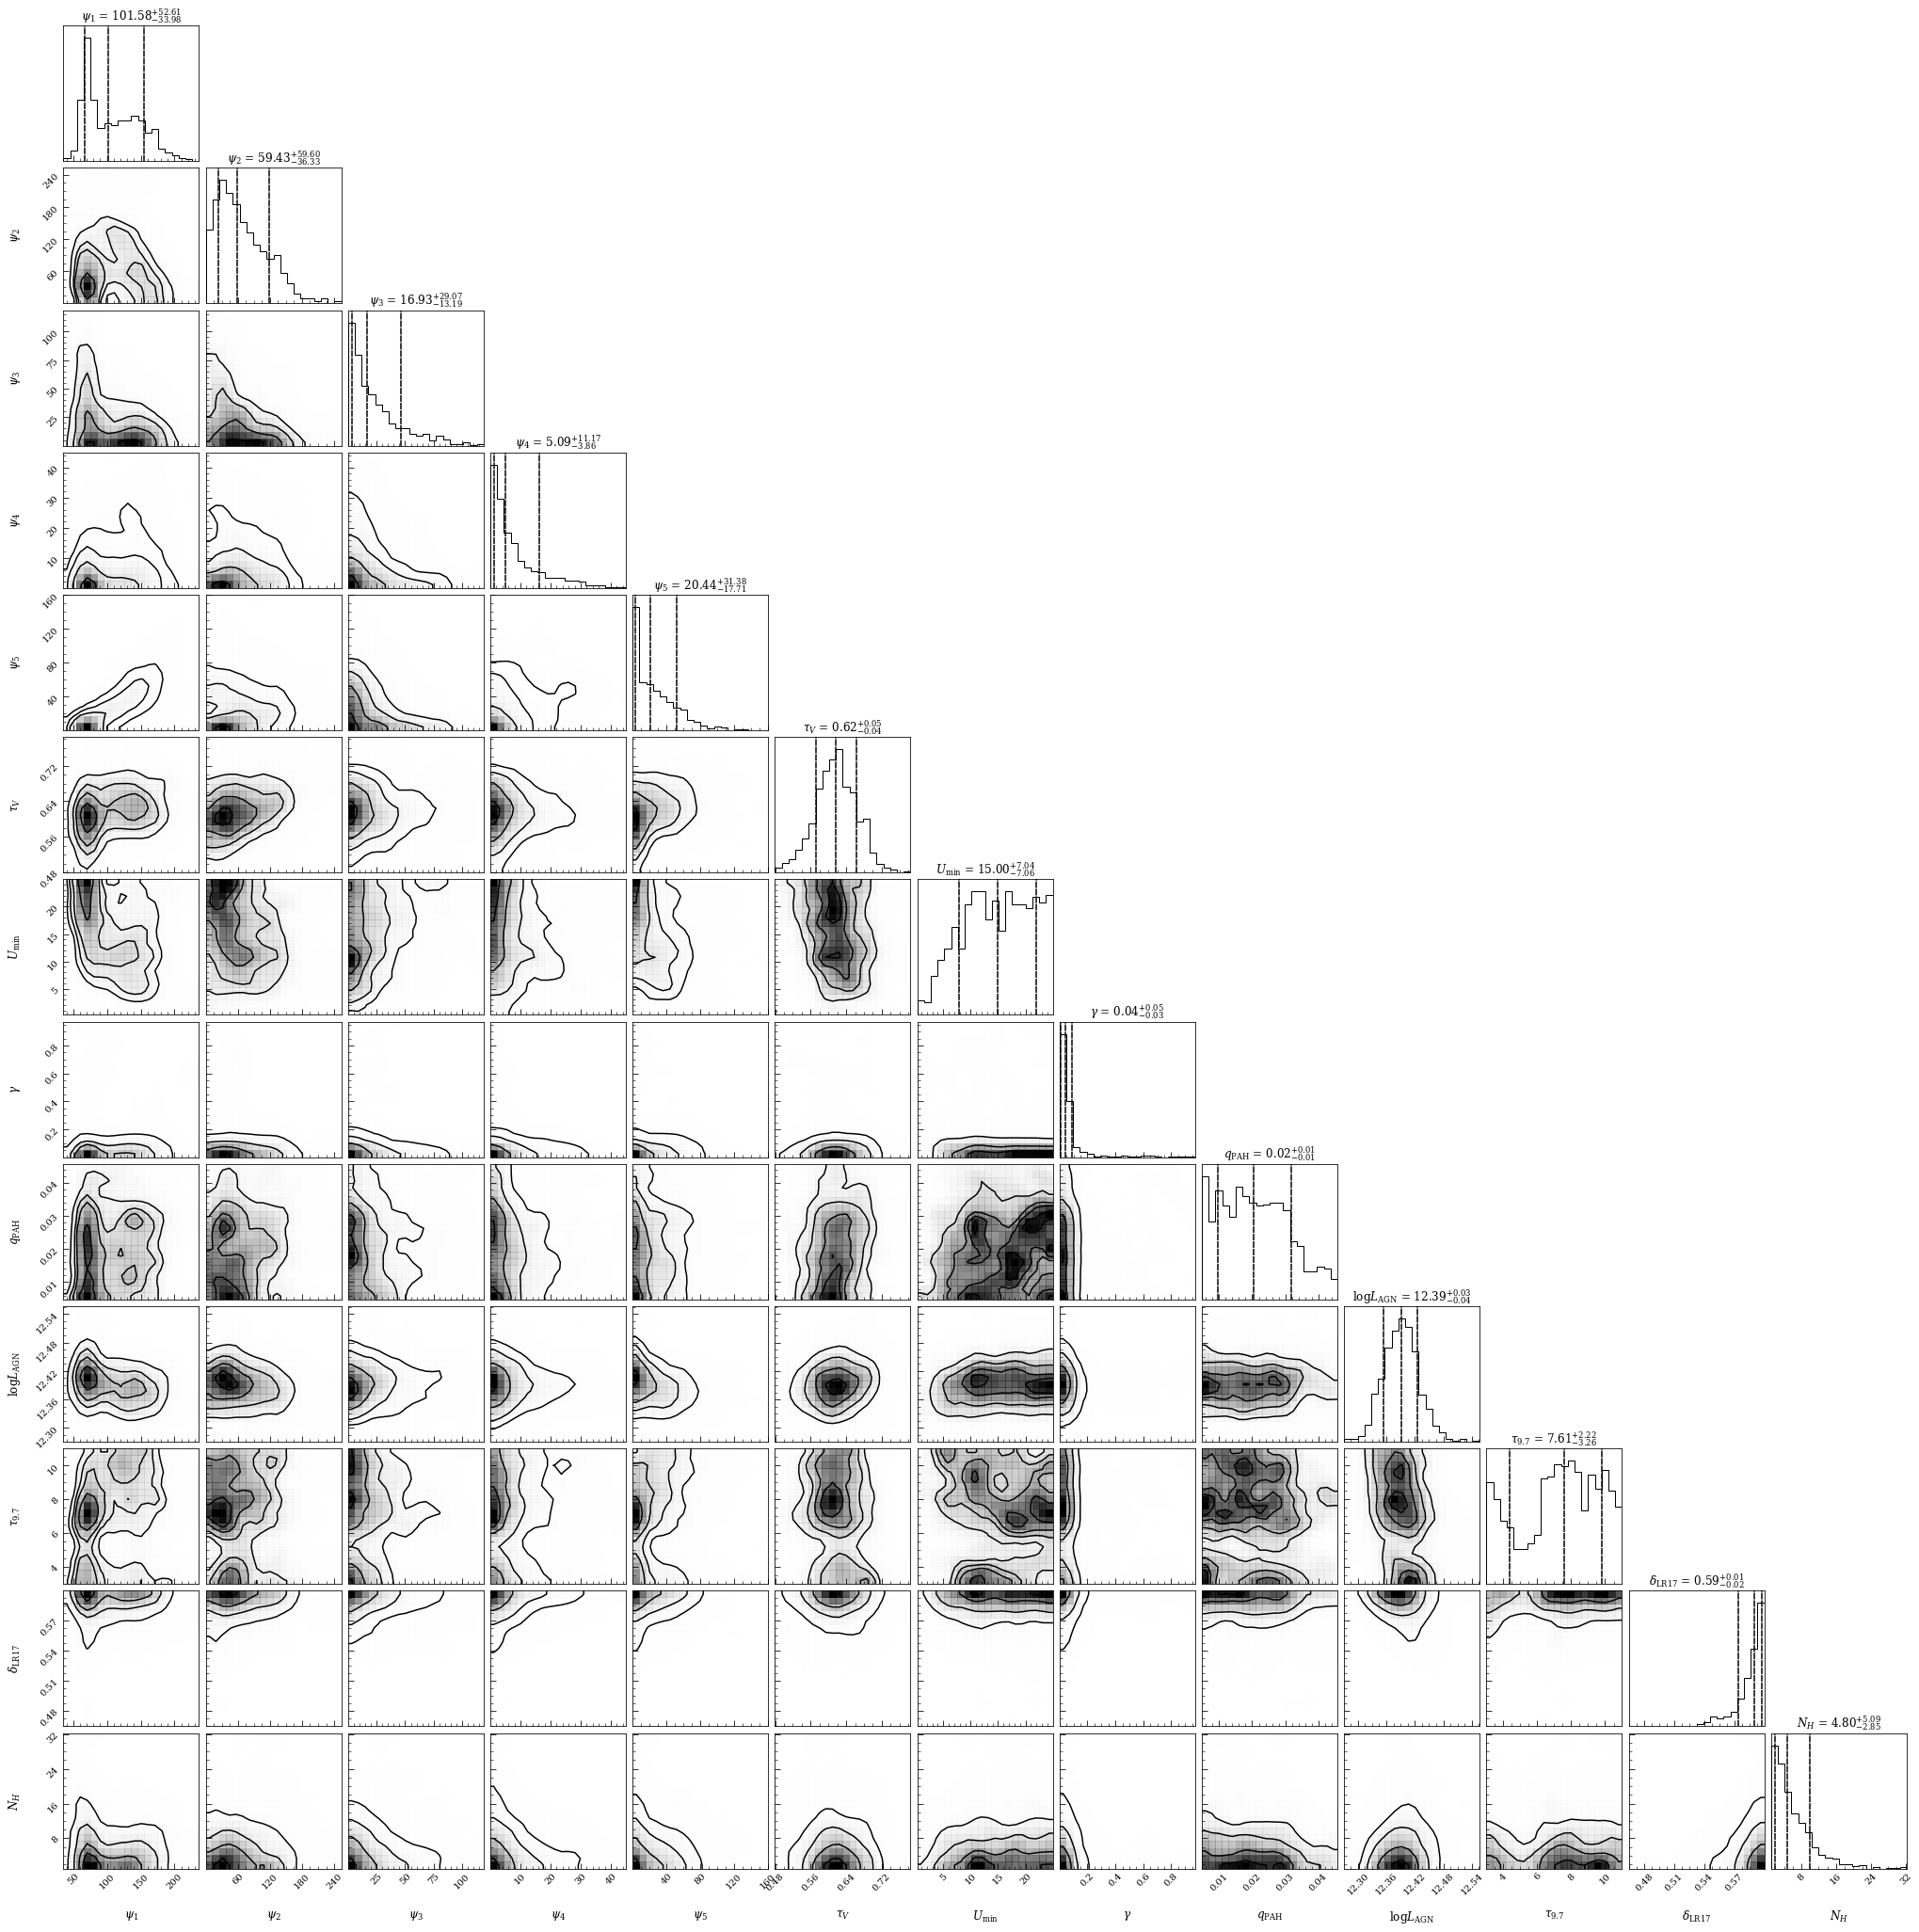

In [11]:
labels = [r'$\psi_1$', r'$\psi_2$', r'$\psi_3$', r'$\psi_4$', r'$\psi_5$',
          r'$\tau_V$', r'$U_{\rm min}$', r'$\gamma$', r'$q_{\rm PAH}$',
          r'$\log L_{\rm AGN}$', r'$\tau_{9.7}$', 
          r'$\delta_{\rm LR 17}$', r'$N_H$']

# levels = np.array([0.68])
# levels_sigma = np.array([1,2,3])
# levels = 1 - np.exp(-0.5 * levels_sigma ** 2)
# print(levels)

fig = corner(chain,
             labels=labels,
             quantiles=(0.16, 0.50, 0.84),
             smooth=1,
             levels=None,
             show_titles=True)

In [12]:
# Get best-fitting SED
bestfit = np.argmax(logprob_chain)
bestfit_samples = chain[bestfit,:]
bestfit_params = p
bestfit_params[var_dim] = bestfit_samples

lnu_hires_best, lnu_hires_intr_best = l2.get_model_lnu_hires(bestfit_params)
lnu_best, lnu_intr_best = l2.get_model_lnu(bestfit_params)

lnu_xray_hires_best, lnu_xray_hires_intr_best = l2.get_xray_model_lnu_hires(bestfit_params)
lnu_xray_best, lnu_xray_intr_best = l2.get_xray_model_lnu(bestfit_params)
counts_xray_best = l2.get_xray_model_counts(bestfit_params)
lnu_obs_xray_best = net_counts / counts_xray_best[xray_mask]  * lnu_xray_best[xray_mask]
lnu_unc_xray_best = lnu_obs_xray_best / (net_counts / net_counts_unc)
#lmod_xray = 

lnu_unc_total = np.sqrt(l2.Lnu_unc**2 + (l2.model_unc * lnu_best)**2)
lnu_xray_unc_total = np.sqrt(l2.Lnu_unc**2 + (l2.model_unc * lnu_xray_best)**2)

# Get the quantiles of the SFH
sfh_q = np.quantile(chain[:,:5], q=(0.16, 0.5, 0.84), axis=0)

(1000000.0, 13600000000.0)

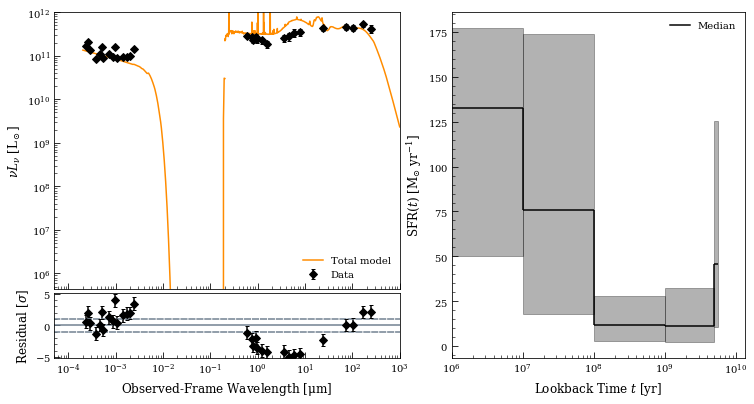

In [27]:
# fig, axs = plt.subplots(1,2, figsize=(12,6))
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_axes([0.1, 0.26, 0.4, 0.64])
ax2 = fig.add_axes([0.1, 0.1, 0.4, 0.15])
ax3 = fig.add_axes([0.56, 0.1, 0.34, 0.8])

# ax1.plot(l.wave_grid_obs, l.nu_grid_obs * lnu_hires_intr_best,
#             color='dodgerblue', label='Intrinsic spectrum')

ax1.plot(l2.wave_grid_obs, l2.nu_grid_obs * lnu_hires_best,
            color='darkorange', label='Total model')

ax1.errorbar(l2.wave_obs, l2.nu_obs * l2.Lnu_obs, yerr=l2.nu_obs * lnu_unc_total,
             marker='D', color='k', markerfacecolor='k', capsize=2, linestyle='',
             label='Data')

# ax1.errorbar(l.wave_obs, l.nu_obs * Lmod, yerr=0,
#              marker='D', color='limegreen', markerfacecolor='limegreen', capsize=2, linestyle='',
#              label='Truth')

# ax1.plot(l.xray_stellar_em.wave_grid_obs,
#          l.xray_stellar_em.nu_grid_obs * lnu_xray_hires_intr_best,
#          color='dodgerblue')
ax1.plot(l2.xray_stellar_em.wave_grid_obs,
         l2.xray_stellar_em.nu_grid_obs * lnu_xray_hires_best,
         color='darkorange')
ax1.errorbar(l2.xray_stellar_em.wave_obs[xray_mask],
             l2.xray_stellar_em.nu_obs[xray_mask] * lnu_obs_xray_best,
             yerr=lnu_unc_xray_best,
             marker='D', color='k', markerfacecolor='k', capsize=2, linestyle='')
# ax1.errorbar(l.xray_stellar_em.wave_obs,
#              l.xray_stellar_em.nu_obs * Lmod_xray,
#              yerr=0,
#              marker='D', color='limegreen', markerfacecolor='limegreen', capsize=2, linestyle='')

#ax1.set_xlabel(r'Observed-Frame Wavelength $[\rm \mu m]$')
ax1.set_ylabel(r'$\nu L_{\nu}\ [\rm L_\odot]$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(5e-5, 1e3)
ax1.set_ylim(0.9 * 5e5, 1e12)
ax1.legend(loc='lower right')
ax1.set_xticklabels([])

delchi = (l2.Lnu_obs - lnu_best) / lnu_unc_total

ax2.axhline(0, color='slategray', linestyle='-')
ax2.axhline(-1, color='slategray', linestyle='--')
ax2.axhline(1, color='slategray', linestyle='--')

ax2.errorbar(l2.wave_obs, delchi, yerr=(1 + np.zeros_like(delchi)),
             marker='D', color='k', markerfacecolor='k', capsize=2, linestyle='')

#delchi_xray = (l.Lnu_obs - lnu_xray_best) / lnu_xray_unc_total
delchi_xray = (net_counts - counts_xray_best[xray_mask]) / net_counts_unc

ax2.errorbar(l2.xray_stellar_em.wave_obs[xray_mask],
             delchi_xray,
             yerr=(1 + np.zeros_like(delchi_xray)),
             marker='D',
             color='k',
             markerfacecolor='k',
             capsize=2,
             linestyle='')

ax2.set_xscale('log')
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(-5.1,5.1)

ax2.set_xlabel(r'Observed-Frame Wavelength $[\rm \mu m]$')
ax2.set_ylabel(r'Residual $[\sigma]$')

# Making nice step plots remains an annoyance
#print(sfh_q.shape)
for i in np.arange(len(l2.ages) - 1):
    ax3.fill_between([l2.ages[i], l2.ages[i+1]],
                        [sfh_q[0,i], sfh_q[0,i]], 
                        [sfh_q[2,i], sfh_q[2,i]],
                        color='k', alpha=0.3)
    lines = ax3.hlines(sfh_q[1,i], l2.ages[i], l2.ages[i+1], color='k')
    if (i < len(l2.ages) - 2): 
        ax3.vlines(l2.ages[i+1], sfh_q[1,i], sfh_q[1,i+1], color='k')

ax3.legend([lines], ['Median'], loc='upper right')

ax3.set_xlabel(r'Lookback Time $t$ [yr]')
ax3.set_ylabel(r'${\rm SFR}(t)\ [\rm M_{\odot}\ yr^{-1}]$')
        
ax3.set_xscale('log')
ax3.set_xlim(1e6,13.6*10**9)